In [1]:
#####################################
### packages required to run code ###
#####################################
import re,string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import os
from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#####################################
### function to process documents ###
#####################################

def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))

    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]

    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]

    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]

    #lowercase all words
    tokens = [word.lower() for word in tokens]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]     

    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    
    return tokens 

In [3]:
##################################
### function to label encoding ###
##################################
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

In [4]:
##################################
### processing text into lists ###
##################################

# set working Directory to where class corpus is saved.
os.chdir('/Users/shaner/Downloads/')

# read in class corpus csv into python
data=pd.read_csv('2023_Winter_453_Class_Corpus.csv')

# create empty list to store text documents titles
titles=[]
#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

# create empty list to store text documents
text_body=[]

# for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

# note: the text_body is the unprocessed list of documents read directly form the csv
    
# empty list to store processed documents
processed_text=[]

# for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

# note: the processed_text is the PROCESSED list of documents read directly form the csv. 
# note the list of words is separated by commas.
# stitch back together individual words to reform body of text.

final_processed_text=[]
for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)
    
# note: we stitched the processed text together so the tfidf vectorizer can work.
# final section of code has 3 lists used.  2 of which are used for further processing.
# (1) text_body - unused, (2) processed_text (used in W2V), 
# (3) final_processed_text (used in tfidf), and (4) DSI titles (used in tfidf matrix)

In [5]:
#####################
### sklearn tfidf ###
#####################

# note the ngram_range will allow you to include multiple words within the tfidf matrix

# call tfidf vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,1))

# fit the vectorizer using final processed documents. the vectorizer requires the stiched back together document
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)  

# creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
############################
### Explore TFIDF Values ###
############################

average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])
average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()
average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)

#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]

#can export matrix to csv and explore further if necessary

In [7]:
###############
### doc2vec ###
###############

documents = [TaggedDocument(doc, [i]) for i, doc in 
enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=800, window=2, min_count=1, workers=4)
doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)
doc2vec_df=doc2vec_df.reset_index()
doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)
doc2vec_df=pd.concat([doc2vec_df,t], axis=1)
doc2vec_df=doc2vec_df.drop('index', axis=1)

doc2vec_df

,0,1,2,3,4,5,6,7,8,9,...,791,792,793,794,795,796,797,798,799,title
0,0.000080,-3.456665e-04,-0.000292,-0.000571,-0.000433,-0.000270,-1.457565e-05,-0.000068,-0.000584,-0.000090,...,-0.000258,0.000103,0.000586,-0.000531,0.000579,-0.000258,-0.000588,-0.000539,-0.000363,YY_Doc2_Vehicles-To-Ukraine.docx
1,-0.000526,5.205991e-04,-0.000054,0.000218,0.000307,0.000183,4.583354e-04,-0.000355,-0.000524,0.000317,...,-0.000014,-0.000329,-0.000101,0.000047,-0.000215,-0.000210,0.000275,-0.000518,-0.000368,SLF_Doc1_US-Restricts-Semiconductor.docx
2,0.000430,5.613554e-04,-0.000322,0.000305,-0.000015,-0.000166,4.306166e-04,0.000102,-0.000148,-0.000554,...,-0.000558,0.000440,-0.000358,0.000340,-0.000078,0.000438,-0.000084,0.000133,-0.000305,453_Yeh_Document1.docx
3,0.000193,-7.897616e-08,-0.000334,-0.000159,0.000031,0.000026,4.036903e-04,0.000124,-0.000050,0.000155,...,0.000290,-0.000018,-0.000572,0.000505,0.000463,0.000239,0.000377,0.000516,-0.000320,XS_Doc1_U.S.-China-relations.docx
4,0.000407,7.823139e-05,-0.000418,0.000156,0.000163,-0.000473,-2.883401e-04,-0.000149,0.000069,0.000410,...,-0.000086,0.000136,0.000523,-0.000220,0.000135,-0.000044,0.000030,-0.000133,0.000245,SLF_Doc2_No-Possibility-Reconciliation.docx
5,-0.000028,-4.880918e-04,-0.000134,0.000041,0.000235,0.000624,1.898877e-04,0.000183,-0.000482,-0.000084,...,0.000075,-0.000502,-0.000382,0.000277,-0.000160,0.000058,-0.000003,0.000360,0.000432,CVL-Doc1-House-Passes-Inflation.docx
6,-0.000158,-3.165587e-04,0.000480,0.000139,0.000490,0.000224,1.177832e-04,-0.000159,0.000254,0.000018,...,-0.000219,0.000084,-0.000322,-0.000126,0.000493,-0.000054,0.000251,0.000239,-0.000052,PK_Doc2_Biden-Escalates-Economic.docx
7,0.000424,-4.572271e-04,-0.000594,-0.000028,0.000341,0.000309,5.130051e-04,0.000594,0.000487,0.000114,...,0.000364,-0.000611,-0.000372,0.000440,-0.000413,0.000212,-0.000361,0.000466,-0.000260,453_Leo_Moreno_Document2.docx
8,0.000099,1.152536e-04,-0.000245,-0.000240,-0.000162,-0.000429,2.600122e-04,-0.000507,-0.000449,0.000518,...,-0.000152,-0.000062,0.000024,0.000613,-0.000401,-0.000072,-0.000058,0.000073,0.000407,CVL-Doc2-A-Closer-Look.docx
9,-0.000189,-1.298713e-04,-0.000391,0.000571,0.000428,-0.000325,-2.642318e-04,-0.000031,-0.000510,-0.000337,...,-0.000552,0.000558,0.000248,0.000253,-0.000621,-0.000324,-0.000014,0.000615,-0.000211,RDA_Doc1_Renters-Struggle-to.docx


In [ ]:
#######################
### gensim word2vec ###
#######################

# note, there are opportunities to use the word2vec matrix to determine words which are similar.  
# similar words can be used to create equivalent classes.  
# k-means is not used to group individual words using the word2vec output.

# word to vec
model_w2v = Word2Vec(processed_text, vector_size=100, window=5, min_count=1, workers=4)

# join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

# obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

# can also use the get_feature_names() from TFIDF to get the list of words
# w2v_words=Tfidf.get_feature_names()

# empty dictionary to store words with vectors
w2v_vectors={}

# for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

# create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

In [14]:
#the following section runs applies the k-means algorithm on the Tfidf matrix.

##################################
### k means clustering - Tfidf ###
##################################

k=5
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()
terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
print("Top terms per cluster:")
# sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
terms_dict=[]
# save the terms for each cluster and document to dictionaries.  
# to be used later for plotting output.

# dictionary to store terms and titles
cluster_terms={}
cluster_title={}

for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

Top terms per cluster:
Cluster 0:
 china
 chips
 advanced
 restrictions
 semiconductors
 trump
 tariffs
 chinese
 semiconductor
 trade
Cluster 0 titles: SLF_Doc1_US-Restricts-Semiconductor.docx, SLF_Doc2_No-Possibility-Reconciliation.docx, PK_Doc2_Biden-Escalates-Economic.docx,Cluster 1:
 taiwan
 china
 meeting
 biden
 policy
 changed
 monday
 beijing
 chinese
 island
Cluster 1 titles: XS_Doc1_U.S.-China-relations.docx, XS_Doc2_Biden-Xi-sitdown.docx, PK_Doc1_BIden-Tells-Xi.docx, PK_Doc1_BIden-Tells-Xi(1).docx,Cluster 2:
 inflation
 prices
 democrats
 climate
 reduce
 policies
 costs
 price
 prescription
 billion
Cluster 2 titles: CVL-Doc1-House-Passes-Inflation.docx, CVL-Doc2-A-Closer-Look.docx, SJR_Doc2_US-Inflation-Eased.docx, SJR_Doc1_Sobering-Inflation-Report.docx,Cluster 3:
 charging
 electric
 chargers
 network
 stations
 vehicle
 vehicles
 states
 public
 really
Cluster 3 titles: RDA_Doc1_Renters-Struggle-to.docx, RDA_Doc2_Biden-Administration-Approves.docx,Cluster 4:
 ukraine
 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


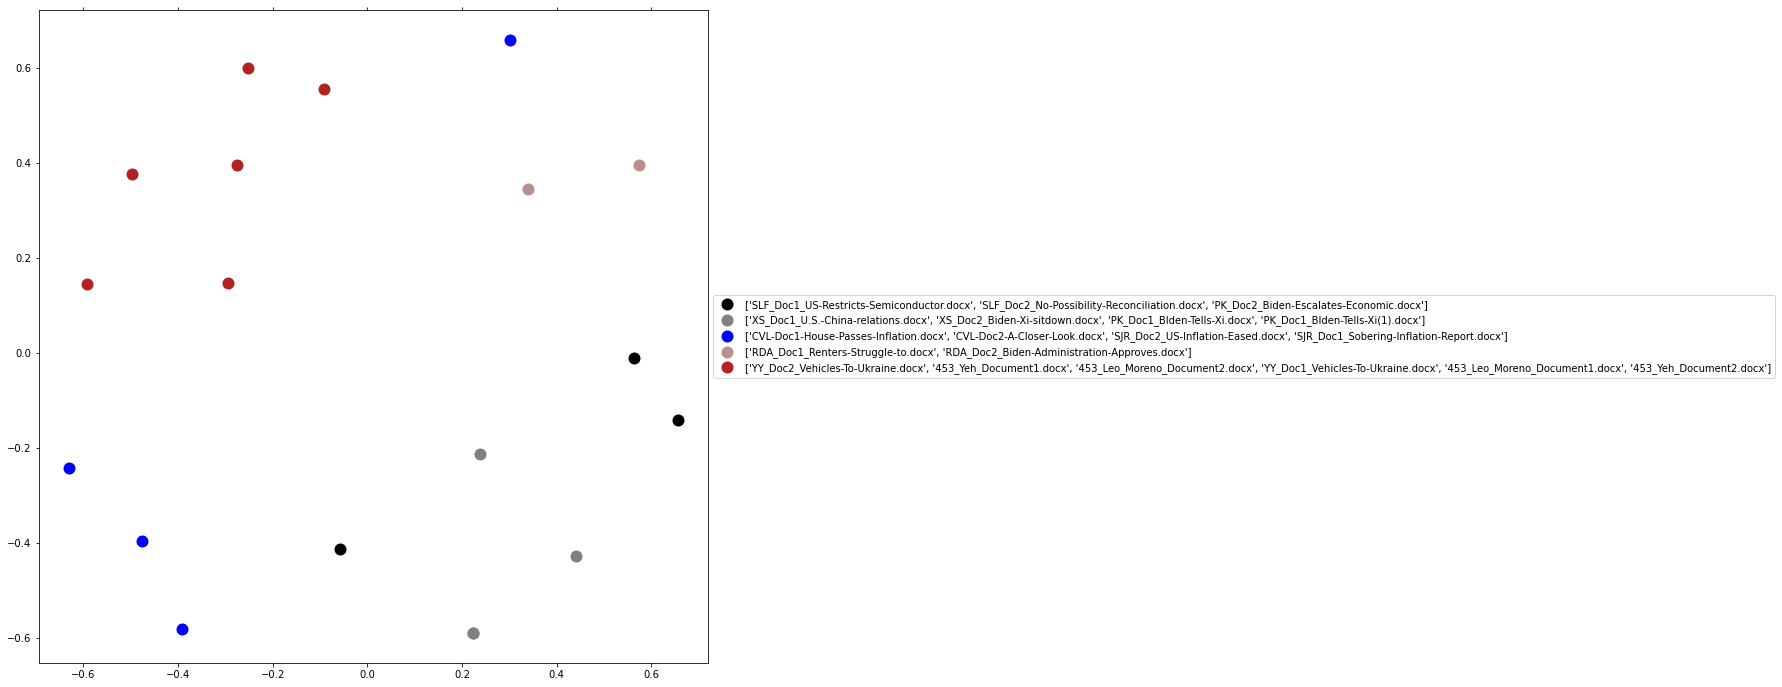

In [9]:
################
### plotting ###
################

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
dist = 1 - cosine_similarity(TFIDF_matrix)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

# set up colors per clusters using a dict.  number of colors must correspond to k
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick',
                  5:'red', 6:'darksalmon', 7:'sienna'}

# set up cluster names using a dict
cluster_dict=cluster_title

# create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot.
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to
# return the appropriate color/label.
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [10]:
# the following section of code is to run the k-means algorithm on the doc2vec outputs.
# note the differences in document clusters compared to the TFIDF matrix.

##################################
### k means clustering doc2vec ###
##################################

doc2vec_k_means=doc2vec_df.drop('title', axis=1)

k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()
#terms = doc2vec_df.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': 
final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
print("Top terms per cluster:")
# sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
terms_dict=[]
# save the terms for each cluster and document to dictionaries.  
# to be used later for plotting output.

# dictionary to store clusters and respective titles
cluster_terms={}
cluster_title={}

# note doc2vec clusters will not have individual words due to the vector representation
# is based on the entire document not indvidual words. As a result, there won't be individual
# word outputs from each cluster.   
for i in range(k):
    print("Cluster %d:" % i),
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])

    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

Top terms per cluster:
Cluster 0:
 common
 advances
 highspeed
 defuse
 connect
 acknowledges
 culmination
 fears
 income
 confirmed
Cluster 0 titles: PK_Doc1_BIden-Tells-Xi.docx, PK_Doc1_BIden-Tells-Xi(1).docx,Cluster 1:
 imposed
 depending
 believed
 deliveries
 close
 exporting
 authorized
 emphatic
 entity
 company
Cluster 1 titles: PK_Doc2_Biden-Escalates-Economic.docx, CVL-Doc2-A-Closer-Look.docx, RDA_Doc1_Renters-Struggle-to.docx, SJR_Doc2_US-Inflation-Eased.docx,Cluster 2:
 attempt
 front
 exchanging
 across
 annual
 costs
 include
 cheats
 fight
 artificialintelligence
Cluster 2 titles: 453_Yeh_Document1.docx,Cluster 3:
 capped
 drawn
 customers
 chinaus
 cornell
 challenges
 antiarmor
 defense
 advisor
 expands
Cluster 3 titles: YY_Doc2_Vehicles-To-Ukraine.docx, SLF_Doc2_No-Possibility-Reconciliation.docx, YY_Doc1_Vehicles-To-Ukraine.docx, SJR_Doc1_Sobering-Inflation-Report.docx,Cluster 4:
 howitzers
 coercive
 chinaus
 extraordinary
 august
 conservative
 inflation
 facetofa

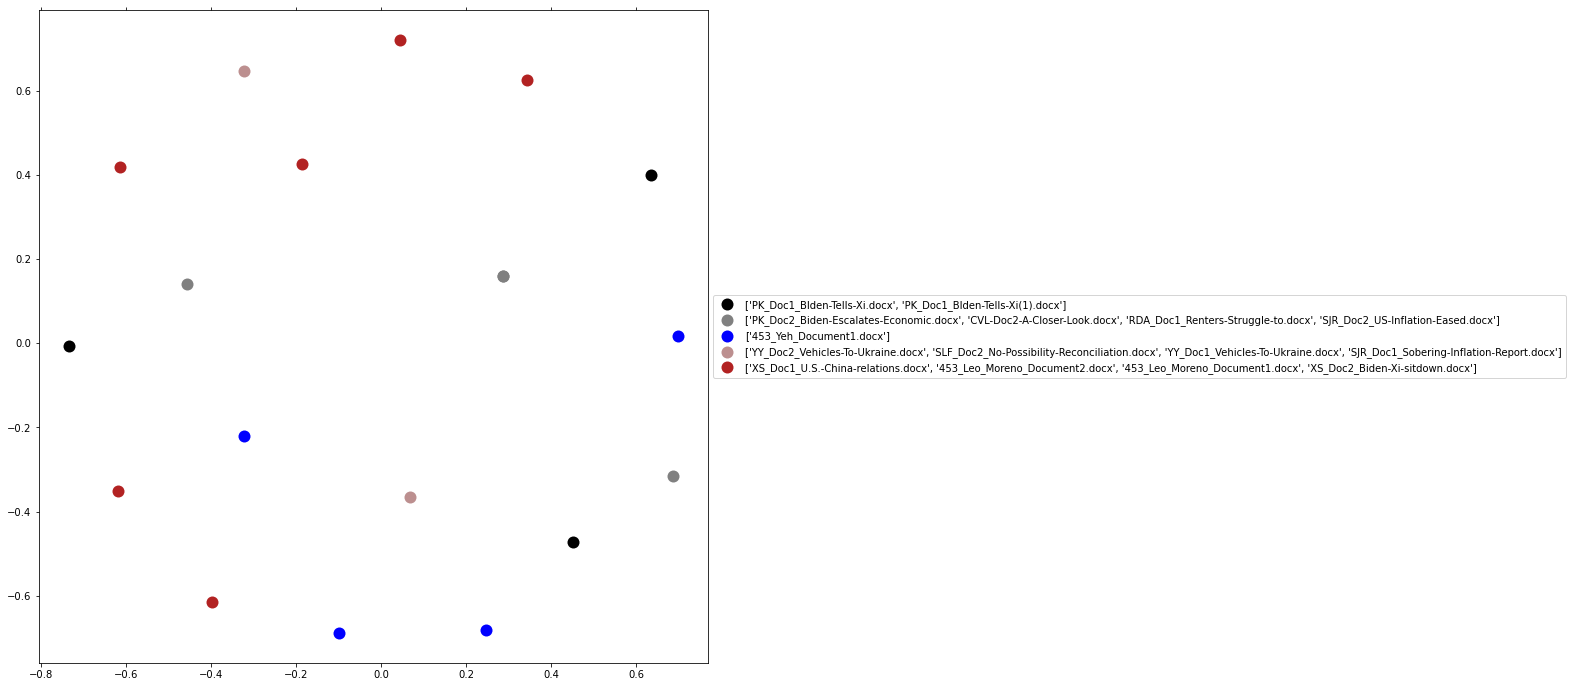

In [11]:
########################
### plotting doc2vec ###
########################

# convert two components as we're plotting points in a two-dimensional plane.
# "precomputed" because we provide a distance matrix.
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
dist = 1 - cosine_similarity(doc2vec_k_means)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

# set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick',
                  5:'red', 6:'darksalmon', 7:'sienna'}

# set up cluster names using a dict.  
cluster_dict=cluster_title         

# create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

# group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot.
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to
# return the appropriate color/label.
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [ ]:
# the following section is used to create a model to predict the cluster's labels 
# based on the the TFIDF matrix and the doc2vec vectors. note the model performance
# using the two different vectorization methods.

#############################################
### classification using various rf model ###
#############################################

model_RF=RandomForestClassifier()

# Tfidf
Y=clusters
X=TFIDF_matrix

# cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=2)

# mean cv score
np.mean(cv_score)

# doc2vec
Y=clusters_d2v
X=doc2vec_k_means

# cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=2)

# mean cv score
np.mean(cv_score)

In [ ]:
# the following section is example code to create ECs within the corpus.  a dictionary
# will need to be created for every EC.  Each EC will need to be applied to the corpus.
# below is an example of how the function works.

########################
### ec clean up code ###
########################

def create_ec(dictionary, corpus):
    for key, values in dictionary.items():
        for value in values:
            corpus= corpus.replace(value, key)
    return corpus
corpus='i like swiss.  i like cheddar.  i like provolone.'
cheese_dic={'cheese': ['swiss', 'cheddar', 'provolone']}
corpus_new=create_ec(cheese_dic, corpus)

In [13]:
################
### lda code ###
################

# lda using bag of words
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in processed_text]
#ldamodel = LdaMulticore(corpus, num_topics=3, id2word=dictionary, passes=2, 
#workers=2)    
#for idx, topic in ldamodel.print_topics(-1):
    #print('Topic: {} \nWords: {}'.format(idx, topic))

# lda using Tfidf
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
ldamodel = LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, 
workers=2)    
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.002*"ukraine" + 0.002*"charging" + 0.002*"vehicles" + 0.001*"infantry" + 0.001*"armored" + 0.001*"rounds" + 0.001*"artillery" + 0.001*"foreign" + 0.001*"additional" + 0.001*"german"
Topic: 1 
Words: 0.001*"tariffs" + 0.001*"ukraine" + 0.001*"trump" + 0.001*"china" + 0.001*"fighting" + 0.001*"ukrainian" + 0.001*"taiwan" + 0.001*"charging" + 0.001*"russia" + 0.001*"forces"
Topic: 2 
Words: 0.001*"chips" + 0.001*"advanced" + 0.001*"semiconductor" + 0.001*"battlefield" + 0.001*"rules" + 0.001*"ukraine" + 0.001*"nationalsecurity" + 0.001*"restrictions" + 0.001*"already" + 0.001*"support"
Topic: 3 
Words: 0.003*"taiwan" + 0.001*"china" + 0.001*"policy" + 0.001*"policies" + 0.001*"stability" + 0.001*"peace" + 0.001*"changed" + 0.001*"meeting" + 0.001*"monday" + 0.001*"reduce"
Topic: 4 
Words: 0.001*"china" + 0.001*"semiconductors" + 0.001*"november" + 0.001*"relationship" + 0.001*"prices" + 0.001*"commerce" + 0.001*"north" + 0.001*"october" + 0.001*"since" + 0.001*"restrict